In this notebook I try to render consecutive scenes (each scene is a time point) into a movie in pyvista.  
Previous notebook: `pyvista_test_import_and_mesh_creation`

In [1]:
import pyvista as pv
import numpy as np
import netCDF4 as nc
import gemgis as gg

/home/ella/miniconda3/envs/pyvista/lib/python3.11/site-packages/gemgis/gemgis.py:27: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
#Environment Report for Reproducibilty

## Just some useful debugging info if you have any issues
pv.Report(["netCDF4", "tqdm"])

--------------------------------------------------------------------------------
  Date: Thu Dec 29 15:54:57 2022 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4
        GPU Vendor : Intel
      GPU Renderer : Mesa Intel(R) HD Graphics 620 (KBL GT2)
       GPU Version : 4.6 (Core Profile) Mesa 22.0.5

  Python 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC
  10.4.0]

           netCDF4 : 1.6.2
              tqdm : 4.64.1
           pyvista : 0.37.0
               vtk : 9.2.2
             numpy : 1.24.0
           imageio : 2.23.0
            scooby : 0.7.0
             pooch : v1.6.0
        matplotlib : 3.6.2
           IPython : 8.7.0
          colorcet : 3.0.1
           cmocean : 2.0
             scipy : 1.9.3
        jupyterlab : 3.5.2
--------------------------------------------------------------------------------

In [22]:
dataset_path = 'UFZ_RemoteSensing/HOLAPS-H-JJA_anomaly-d-2001-2005.nc'
heat_var = 'surface_upward_sensible_heat_flux'
fill_value=-999

n_timepoints = 10

In [23]:
ds = nc.Dataset(dataset_path)
arr_shape = ds.variables[heat_var].shape

In [59]:
grids = []

#load each timepoint:
for i in range(n_timepoints):
    
    arr = ds[heat_var][i]
    min_val = np.min(arr)
    
    grid = gg.visualization.create_dem_3d(dem=arr.filled(fill_value=fill_value), 
                                          extent=[0,arr_shape[2],0,arr_shape[1]])
    
    grid.rename_array('Elevation','Heat')
    
    grids.append(grid.threshold(int(min_val-2), invert=False, preference='point', all_scalars=True))

In [38]:
grids[0]

UnstructuredGrid (0x7fa68fa13760)
  N Cells:	496394
  N Points:	677386
  X Bounds:	0.000e+00, 2.464e+03
  Y Bounds:	0.000e+00, 1.200e+03
  Z Bounds:	-1.998e+03, 2.380e+02
  N Arrays:	1

## Make movie

In [143]:
time_arr = ds['time'][:]

In [147]:
## args:
clim = [-200, 200]
cmap = 'seismic'
opacity=1

sargs = {"color":"black"}

# Camera position is a tuple: camera location, focus point, viewup vector
# [(x,y,z), (fx,fy,fz,), (nx,ny,nz)]


In [161]:


# initialize the point cloud
#update_pc(0)

## Create our render engine
p = pv.Plotter(notebook=False, off_screen=True, 
               window_size=[1920*2, 1080*2], multi_samples=16) # multi_sample mitigates aliasing - higher is better, but might affect performance.

## Open up an MP4 with a 60 FPS framerate
p.open_movie("test_movie.mp4", framerate=1)

p.set_background('white')

actor = p.add_mesh(mesh=grids[0], clim=clim, cmap=cmap, opacity=opacity, scalar_bar_args=sargs)
actor1 = p.add_text(f'time stamp: {int(time_arr[0])}', position='upper_right', color='blue', shadow=True, font_size=26)

# Camera position is a tuple: camera location, focus point, viewup vector
# [(x,y,z), (fx,fy,fz,), (nx,ny,nz)]

p.camera_position = 'xy'
p.camera.zoom(1.5)

# points = np.array([[200, 200, 150],
#                    [1.0, 1.0, 0.0],
#                    [2.0, 0.0, 0.0]])

# labels = [f'test test test \n test test', 'Point B', 'Point C']

points = np.array([[200., 200., 150.]])
labels = [f'test test test \n test test']

actor2 = p.add_point_labels(points, labels, italic=True, font_size=20,
                            shape_color='black', name='test',
                            point_color='green', point_size=20,
                            render_points_as_spheres=True,
                            always_visible=True, shadow=True)

# p.camera_position =[(-283.285811675846, -1597.1397046051004, 1155.542325449192),
#                     (577.9371599370799, 495.3480261506809, 381.7124055285182),
#                     (0.17313457304419916, 0.27814381639313923, 0.9448070898437746)]

p.show(auto_close=False)

## Run through each frame
p.write_frame()  ## write initial data

for i in range(1,n_timepoints):
    p.remove_actor(actor)
    p.remove_actor(actor1)
    p.remove_actor(actor2)
    p.remove_actor('test')
    actor = p.add_mesh(mesh=grids[i], clim=clim, cmap=cmap, opacity=opacity, scalar_bar_args=sargs)
    actor1 = p.add_text(f'time stamp: {int(time_arr[i])}', position='upper_right', color='blue', shadow=True, font_size=26)
    
    if i==5:
        actor2 = p.add_point_labels(points, labels, italic=True, font_size=20,
                            shape_color='black', name='test',
                            point_color='green', point_size=20,
                            render_points_as_spheres=True,
                            always_visible=True, shadow=True)

    p.write_frame()
    
pv.close_all()



[rawvideo @ 0x5b24580] Stream #0: not enough frames to estimate rate; consider increasing probesize


True

In [153]:
p.add_point_labels?

Signature:
p.add_point_labels(
    points,
    labels,
    italic=False,
    bold=True,
    font_size=None,
    text_color=None,
    font_family=None,
    shadow=False,
    show_points=True,
    point_color=None,
    point_size=5,
    name=None,
    shape_color='grey',
    shape='rounded_rect',
    fill_shape=True,
    margin=3,
    shape_opacity=1.0,
    pickable=False,
    render_points_as_spheres=False,
    tolerance=0.001,
    reset_camera=None,
    always_visible=False,
    render=True,
)
Docstring:
Create a point actor with one label from list labels assigned to each point.

Parameters
----------
points : sequence or pyvista.DataSet
    An ``n x 3`` sequence points or pyvista dataset with points.

labels : list or str
    List of labels.  Must be the same length as points. If a
    string name is given with a :class:`pyvista.DataSet` input for
    points, then these are fetched.

italic : bool, optional
    Italicises title and bar labels.  Default ``False``.

bold : bool, option

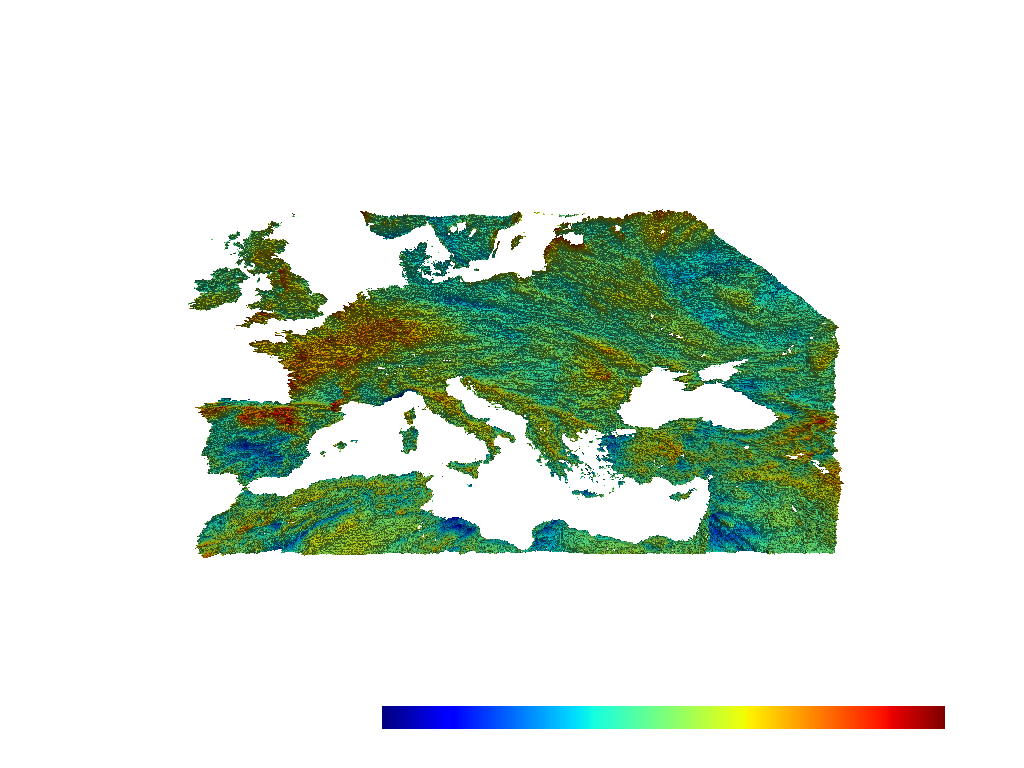

In [116]:
# If needed:
## test problem with timepoint x
x = 0

p = pv.Plotter()

p.add_mesh(mesh=grids[x], cmap='jet')
###, scalars=grid["Elevation"], cmap='gist_earth')

p.camera_position =[(500, -1000, 1500),
                    (600, -200, 400),
                    (0.4, 0.2, 0.5)]

p.camera_position = 'xy'

#p.show_grid(color='black')
p.set_background(color='white')
p.show()